# <p style="text-align: center;"> <a href='https://www.kaggle.com/c/digit-recognizer'>Kaggle competition: Digit Recognizer</a></p>
* [Logistic regression](#logistic-regression)
* [KNN](#knn)
* [SVM](#svm)
* [CNN](#cnn)

# Preparation

In [30]:
%matplotlib inline
import logging
import numpy as np
import pandas as pd
import timeit
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

logger = logging.getLogger()
logger.setLevel(logging.INFO)

train_data = pd.read_csv('./train.csv').sample(frac=1)
submission_test_data = pd.read_csv('./test.csv')
pixel_columns = ['pixel' + str(i) for i in range(784)]

X_train, X_test, y_train, y_test = train_test_split(train_data[pixel_columns], train_data['label'], test_size=0.20)

In [31]:
# Some functions

def plot_result(y_truth, y_pred):
    prec, recall, _, _ = precision_recall_fscore_support(y_truth, y_pred, average='macro')
    print("Precision: %.2f  - Recall: %.2f" % ((prec * 100,recall * 100)))

## Train on 80% of data, Test on 20% of data

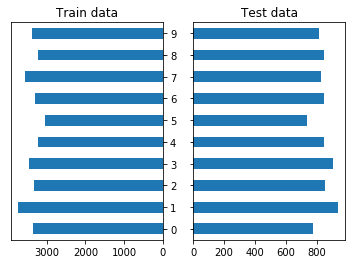

In [32]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
ax.invert_xaxis()
ax.yaxis.tick_right()
y_train.value_counts().sort_index().to_frame().plot.barh(ax=ax, title="Train data", legend=False)
y_test.value_counts().sort_index().to_frame().plot.barh(ax=ax2, title="Test data", legend=False)
plt.show()

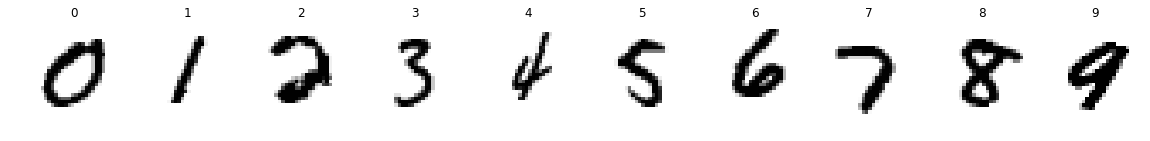

In [33]:
plt.figure(num='digit',figsize=(20, 5))
for idx, row in train_data.sample(frac=1).sort_values(by=['label']).drop_duplicates(subset=['label']).iterrows():
    image = np.array(row[pixel_columns]).reshape([-1,28,28,1])
    plt.subplot(1, 10, row['label'] + 1)
    plt.title(row['label'])
    plt.axis('off')
    plt.imshow(np.squeeze(image),cmap=plt.cm.binary)

## <a class="anchor" id="logistic-regression">Logistic regression</a>

In [47]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', multi_class='multinomial')

s = timeit.default_timer()
clf.fit(X_train, y_train)
logistic_regression_training_time = timeit.default_timer() - s
print("Training time:", logistic_regression_training_time)

s = timeit.default_timer()
y_prediction = clf.predict(X_test)
logicstic_regression_prediction_time = timeit.default_timer() - s
print("Prediction time:", logicstic_regression_prediction_time)

plot_result(y_test, y_prediction)

Training time: 8.248247490000722
Prediction time: 0.01930298099978245
Precision: 91.02  - Recall: 91.06


/home/rictus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic regression is a good start. Many efforts can be made to go up to 92% but that's not worth.

## <a class="anchor" id="knn">KNN</a>

In [50]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

s = timeit.default_timer()
neigh.fit(X_train, y_train)
knn_training_time = timeit.default_timer() - s
print("Training time:", knn_training_time)

s = timeit.default_timer()
y_prediction = neigh.predict(X_test)
knn_prediction_time = timeit.default_timer() - s
print("Prediction time:", knn_prediction_time)
plot_result(y_test, y_prediction)

Training time: 11.85363156999847
Prediction time: 195.87811393599986
Precision: 96.42  - Recall: 96.39


## <a class="anchor" id="svm">SVM</a>

In [35]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo', kernel='poly', degree=2, gamma='auto')

s = timeit.default_timer()
clf.fit(X_train, y_train)
svm_training_time = timeit.default_timer() - s
print("Training time:",svm_training_time)

s = timeit.default_timer()
y_prediction = clf.predict(X_test)
svm_prediction_time = timeit.default_timer() - s
print("Prediction time:",svm_prediction_time)

plot_result(y_test, y_prediction)

Training time: 104.22440049299985
Prediction time: 42.63770349300103
Precision: 97.50  - Recall: 97.50


Polynomial SVC performs well : around 97% of precision and recall. Using a degree of 2 might be because we are working with 2d images.

## Show wrong predictions with title  "truth -> prediction"

ValueError: num must be 1 <= num <= 156, not 157

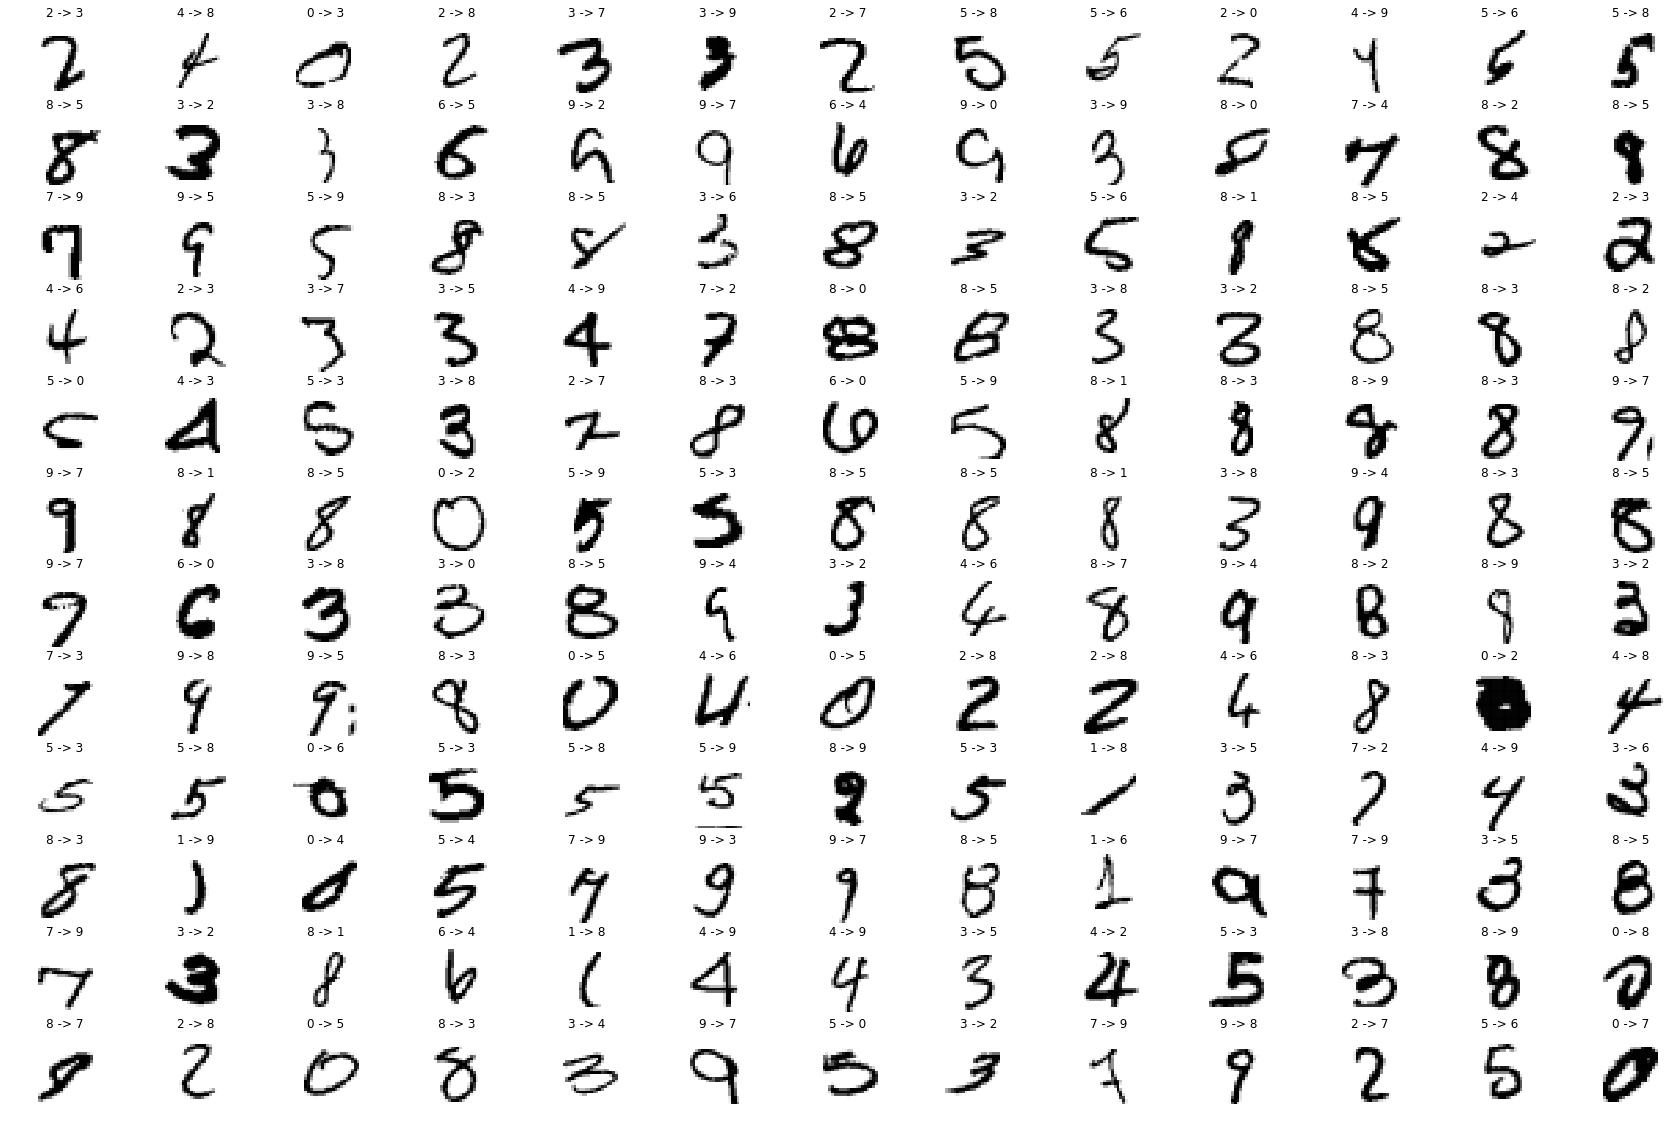

In [49]:
y = pd.DataFrame(zip(y_test, y_prediction), columns=['test', 'pred'])
x_test = X_test.reset_index(drop=True)
wrong_predictions = y.query('test != pred')
wrong_predictions = pd.merge(wrong_predictions, x_test.iloc[list(wrong_predictions.index.values)], left_index=True, right_index=True)
# wrong_predictions['pairs'] = wrong_predictions['test'].map(str) + wro5ng_predictions['pred'].map(str)


cnt = 0
plt.figure(num='digit',figsize=(30, 20))
for _, row in wrong_predictions.iterrows():
    cnt += 1
    image = np.array(row[pixel_columns]).reshape([-1,28,28,1])
    plt.subplot(12, 13, cnt)
    plt.title('%d -> %d' % (row['test'], row['pred']))
    plt.axis('off')
    plt.imshow(np.squeeze(image),cmap=plt.cm.binary)

## Confusion matrix help to identify which digits are missclassified

Confusion matrix, without normalization
[[752   1   3   2   3   5   6   3   3   0]
 [  0 917   7   4   0   0   1   1   8   2]
 [  5  10 761  14  13   5  15  10  19   4]
 [  3   1  23 788   1  40   4   8  24  11]
 [  2   5   3   3 778   2  10   6   5  33]
 [  9   5   5  23   5 644  15   4  20   9]
 [  7   4   4   1   5  12 807   3   3   0]
 [  0   2   9   6   4   0   1 774   3  29]
 [  8  21   8  32   3  34   8   5 719  11]
 [  3   3   3  10  22  10   0  39  10 714]]
Normalized confusion matrix
[[0.97 0.   0.   0.   0.   0.01 0.01 0.   0.   0.  ]
 [0.   0.98 0.01 0.   0.   0.   0.   0.   0.01 0.  ]
 [0.01 0.01 0.89 0.02 0.02 0.01 0.02 0.01 0.02 0.  ]
 [0.   0.   0.03 0.87 0.   0.04 0.   0.01 0.03 0.01]
 [0.   0.01 0.   0.   0.92 0.   0.01 0.01 0.01 0.04]
 [0.01 0.01 0.01 0.03 0.01 0.87 0.02 0.01 0.03 0.01]
 [0.01 0.   0.   0.   0.01 0.01 0.95 0.   0.   0.  ]
 [0.   0.   0.01 0.01 0.   0.   0.   0.93 0.   0.04]
 [0.01 0.02 0.01 0.04 0.   0.04 0.01 0.01 0.85 0.01]
 [0.   0.   0.   0.01 0.

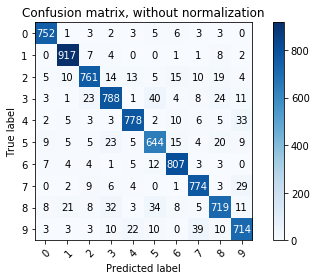

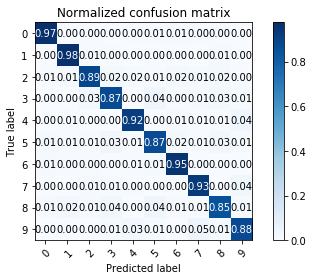

In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_prediction, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_prediction, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## <a class="anchor" id="cnn">CNN</a>